# Long-Term Forecast with Prophet

This notebook uses Facebook's Prophet library to generate long-term forecasts. It's a robust alternative to the previous XGBoost approach, designed to be faster and less error-prone.

We will focus on the `morb_resp` and `morb_circ` datasets.

## 1. Imports and Setup

In [ ]:
%pip install prophet

In [10]:
import pandas as pd
from prophet import Prophet
from pathlib import Path
import sys
import tqdm as tqdm
from sklearn.preprocessing import StandardScaler

# Add src to path to import preprocessing functions
sys.path.append(str(Path().resolve().parent / 'src'))
from preprocessing import load_city_data, filter_city, clean_timeseries

## 2. Forecasting Function

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def forecast_with_prophet(city_df, forecast_end_date="2035-12-31"):
    """
    Trains a Prophet model, generates a long-term univariate forecast,
    and calculates accuracy metrics.
    
    Args:
        city_df (pd.DataFrame): The historical data for the city.
        forecast_end_date (str): The end date for the forecast.
        
    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The forecast dataframe.
            - dict: A dictionary with accuracy metrics (MAE, RMSE).
    """
    # Prophet requires columns 'ds' and 'y'
    df_prophet = city_df.rename(columns={'week': 'ds', 'target': 'y'})
    
    # --- FIX: Create a proper date range for the 'ds' column ---
    # The 'week' column is an integer index (1, 2, ...). We need a real date series.
    # We'll assume a start date. The exact date is less important than the weekly frequency.
    start_date = '2001-01-01' # Arbitrary start date
    num_weeks = len(df_prophet)
    df_prophet['ds'] = pd.date_range(start=start_date, periods=num_weeks, freq='W')

    # Keep original 'y' for metric calculation
    y_original = df_prophet['y'].copy()

    # --- Scale Target ---
    y_scaler = StandardScaler()
    df_prophet['y'] = y_scaler.fit_transform(df_prophet[['y']])
    
    # Initialize and fit the model
    model = Prophet()
    model.fit(df_prophet)
    
    # Create a future dataframe for predictions
    future = model.make_future_dataframe(periods=52*14, freq='W') # ~14 years to reach 2035
    
    # Generate forecast
    forecast = model.predict(future)
    
    # --- Inverse transform the forecast ---
    for col in ['yhat', 'yhat_lower', 'yhat_upper']:
        forecast[col] = y_scaler.inverse_transform(forecast[[col]])

    # Ensure forecast is not negative
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    
    # --- Calculate Metrics on historical data ---
    # Merge forecast with actuals
    metrics_df = forecast.set_index('ds').join(y_original.to_frame().set_index(df_prophet['ds']))
    metrics_df.dropna(inplace=True) # Drop future dates where 'y' is NaN
    
    mae = mean_absolute_error(metrics_df['y'], metrics_df['yhat'])
    rmse = np.sqrt(mean_squared_error(metrics_df['y'], metrics_df['yhat']))
    
    metrics = {'MAE': mae, 'RMSE': rmse}
    
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], metrics

## 3. Single City Test
Here we'll test the forecasting process on a single city (São Paulo) to verify that everything is working correctly before running the full batch process. We'll also plot the results.

### What is `yhat`?
In Prophet's output, `yhat` is the predicted forecast value. The columns `yhat_lower` and `yhat_upper` represent the uncertainty intervals (the lower and upper bounds of the forecast).

18:07:17 - cmdstanpy - INFO - Chain [1] start processing
18:07:17 - cmdstanpy - INFO - Chain [1] done processing
18:07:17 - cmdstanpy - INFO - Chain [1] done processing


--- RUNNING UNIVARIATE TEST. ---

Generating forecast for city 3550308...


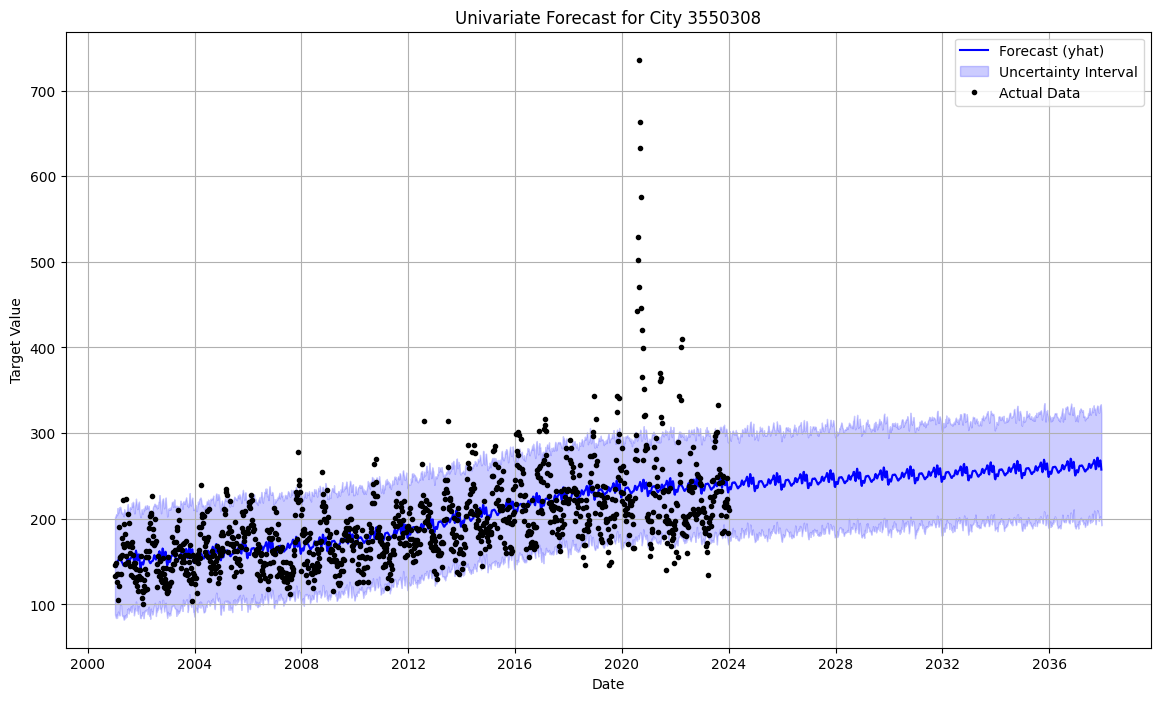


Forecast generated successfully. Head of the forecast data (in original scale):
          ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2001-01-07 -0.790875   88.203618  202.353151    -0.790875    -0.790875   
1 2001-01-14 -0.789958   85.940874  201.936523    -0.789958    -0.789958   
2 2001-01-21 -0.789041   84.154614  205.350155    -0.789041    -0.789041   
3 2001-01-28 -0.788124   88.556242  205.430695    -0.788124    -0.788124   
4 2001-02-04 -0.787207   84.206672  204.052667    -0.787207    -0.787207   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.066716             -0.066716             -0.066716 -0.066716   
1       -0.064397             -0.064397             -0.064397 -0.064397   
2       -0.097255             -0.097255             -0.097255 -0.097255   
3       -0.107935             -0.107935             -0.107935 -0.107935   
4       -0.069939             -0.069939             -0.069939 -0.069939   

   yearly_l

In [12]:
import sys
from pathlib import Path
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Add src to path to import preprocessing functions
# Go up one level from 'notebooks' to the project root
project_root = Path().resolve().parent 
sys.path.insert(0, str(project_root))

from src.preprocessing import load_city_data, filter_city, clean_timeseries

# --- Test on a single city (UNIVARIATE) ---
test_city_code = 3550308  # São Paulo
test_dataset_id = "morb_resp"

# Load data
data_path = project_root / "data"
data_file = data_path / f"df_base_{test_dataset_id}.csv"

if data_file.exists():
    df_full = load_city_data(str(data_file))
    
    # --- UNIVARIATE FORECAST ---
    features_to_use = []
    print(f"--- RUNNING UNIVARIATE TEST. ---")
    
    # Filter and clean
    city_df = filter_city(df_full, test_city_code)
    city_df_cleaned = clean_timeseries(city_df, target_column="target")

    if city_df_cleaned.shape[0] > 104:
        print(f"\nGenerating forecast for city {test_city_code}...")
        
        # --- Prepare data for Prophet ---
        df_prophet = city_df_cleaned.rename(columns={'week': 'ds', 'target': 'y'})
        
        # --- FIX: Create a proper date range for the 'ds' column ---
        start_date = '2001-01-01'
        num_weeks = len(df_prophet)
        df_prophet['ds'] = pd.date_range(start=start_date, periods=num_weeks, freq='W')

        # --- Scale Target ---
        y_scaler = StandardScaler()
        df_prophet['y'] = y_scaler.fit_transform(df_prophet[['y']])

        # --- Train Prophet Model ---
        model = Prophet()
        model.fit(df_prophet)
        
        # --- Create Future Dataframe ---
        future = model.make_future_dataframe(periods=52*14, freq='W') # Forecast to ~2035
        
        # --- Generate and Inverse Transform Forecast ---
        forecast = model.predict(future)
        for col in ['yhat', 'yhat_lower', 'yhat_upper']:
            forecast[col] = y_scaler.inverse_transform(forecast[[col]])
        forecast['yhat'] = forecast['yhat'].clip(lower=0)
        
        # --- Plotting ---
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast (yhat)')
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                        color='blue', alpha=0.2, label='Uncertainty Interval')
        ax.plot(df_prophet['ds'], city_df_cleaned['target'], 'k.', label='Actual Data')
        ax.set_title(f"Univariate Forecast for City {test_city_code}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Target Value")
        ax.legend()
        ax.grid(True)
        plt.show()
        
        print("\nForecast generated successfully. Head of the forecast data (in original scale):")
        print(forecast.head())
        
    else:
        print(f"City {test_city_code} has insufficient data for testing.")
else:
    print(f"Data file not found: {data_file}")

## 4. Main Orchestration

In [13]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
# Ensure src path is added to import preprocessing functions
import sys
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from src.preprocessing import load_city_data, filter_city, clean_timeseries

def generate_all_prophet_forecasts(datasets_to_run):
    """
    Generates and saves long-term UNIVARIATE forecasts for all cities,
    including plots and accuracy metrics. Skips already processed cities.
    """
    base_path = Path().resolve().parent
    data_path = base_path / "data"
    output_path = base_path / "long_term_forecasts_prophet"
    output_path.mkdir(exist_ok=True)

    print(f"Starting Prophet UNIVARIATE forecast generation for: {', '.join(datasets_to_run)}")

    for dataset_id in datasets_to_run:
        print(f"\n--- Processing dataset: {dataset_id} ---")
        
        # Create output directories for this dataset
        dataset_output_path = output_path / dataset_id
        dataset_output_path.mkdir(exist_ok=True)
        plots_output_path = dataset_output_path / "plots"
        plots_output_path.mkdir(exist_ok=True)

        # Load data
        data_file = data_path / f"df_base_{dataset_id}.csv"
        if not data_file.exists():
            print(f"Data file not found for {dataset_id}. Skipping.")
            continue
        
        df_full = load_city_data(str(data_file))
        all_city_codes = sorted(df_full['CD_MUN'].unique())
        
        # --- Check for already processed cities to make the script resumable ---
        existing_files = list(dataset_output_path.glob("*_prophet_forecast.csv"))
        completed_cities = [int(f.stem.split('_')[0]) for f in existing_files]
        
        cities_to_process = [
            code for code in all_city_codes if code not in completed_cities
        ]
        
        if not cities_to_process:
            print(f"All cities in {dataset_id} have already been processed. Skipping.")
            continue
            
        print(f"Found {len(completed_cities)} completed cities. Processing {len(cities_to_process)} remaining cities.")
        
        print("Running in univariate mode (no extra features).")

        for city_code in tqdm(cities_to_process, desc=f"Forecasting cities in {dataset_id}"):
            try:
                city_df = filter_city(df_full, city_code)
                city_df_cleaned = clean_timeseries(city_df, target_column="target")

                if city_df_cleaned.shape[0] < 104: # Need at least 2 years of data for Prophet
                    continue

                # Generate forecast and metrics
                forecast_df, metrics = forecast_with_prophet(city_df_cleaned)
                
                # --- Prepare data for saving (add actuals) ---
                start_date = '2001-01-01'
                num_weeks_actuals = len(city_df_cleaned)
                actuals_ds = pd.date_range(start=start_date, periods=num_weeks_actuals, freq='W')
                city_df_cleaned['ds'] = actuals_ds
                
                output_df = pd.merge(forecast_df, city_df_cleaned[['ds', 'target']], on='ds', how='left')
                output_df.rename(columns={'target': 'actual'}, inplace=True)

                # --- Save Plot ---
                fig, ax = plt.subplots(figsize=(14, 8))
                ax.plot(output_df['ds'], output_df['yhat'], 'b-', label='Forecast (yhat)')
                ax.fill_between(output_df['ds'], output_df['yhat_lower'], output_df['yhat_upper'], 
                                color='blue', alpha=0.2, label='Uncertainty Interval')
                ax.plot(output_df['ds'], output_df['actual'], 'k.', label='Actual Data')
                ax.set_title(f"Univariate Forecast for City {city_code} ({dataset_id})")
                ax.set_xlabel("Date")
                ax.set_ylabel("Cases")
                ax.legend()
                ax.grid(True)
                plot_file = plots_output_path / f"{city_code}_prophet_forecast.png"
                plt.savefig(plot_file)
                plt.close(fig)

                # --- Save forecast and metrics to CSV ---
                output_df['ds'] = output_df['ds'].astype(object)
                metrics_rows = pd.DataFrame([
                    {'ds': 'MAE', 'yhat': metrics['MAE']},
                    {'ds': 'RMSE', 'yhat': metrics['RMSE']}
                ])
                final_csv_df = pd.concat([output_df, metrics_rows], ignore_index=True)
                
                output_file = dataset_output_path / f"{city_code}_prophet_forecast.csv"
                final_csv_df.to_csv(output_file, index=False)

            except Exception as e:
                print(f"\nError processing city {city_code} in {dataset_id}: {e}")
                continue
                
    print("\nProphet forecast generation complete.")

## 5. Run Forecast

In [14]:
datasets = ["morb_resp", "morb_circ"]
generate_all_prophet_forecasts(datasets)

Starting Prophet UNIVARIATE forecast generation for: morb_resp, morb_circ

--- Processing dataset: morb_resp ---
All cities in morb_resp have already been processed. Skipping.

--- Processing dataset: morb_circ ---
All cities in morb_resp have already been processed. Skipping.

--- Processing dataset: morb_circ ---
Found 2383 completed cities. Processing 3124 remaining cities.
Running in univariate mode (no extra features).
Found 2383 completed cities. Processing 3124 remaining cities.
Running in univariate mode (no extra features).


Forecasting cities in morb_circ:   0%|          | 0/3124 [00:00<?, ?it/s]

18:07:29 - cmdstanpy - INFO - Chain [1] start processing
18:07:29 - cmdstanpy - INFO - Chain [1] done processing
18:07:29 - cmdstanpy - INFO - Chain [1] done processing
18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
18:07:30 - cmdstanpy - INFO - Chain [1] done processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1]


Prophet forecast generation complete.


In [6]:
%pip install jupyter

  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached jupyterlab_server-2.27.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached jupyterlab_server-2.27.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached notebook_shim-0.2.4-py3-none-any.whl.metadata (4.0 kB)
  Using cached notebook_shim-0.2.4-py3-none-any.whl.metadata (4.0 kB)
  Using cached jupyter_server_terminals-0.5.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached jupyter_server_terminals-0.5.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using ca